# Imports

In [1]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Read Data

In [2]:
df_og = pd.read_pickle("./rushing-mlr.pkl")

# Multivariate Linear Regression

In [3]:
df = df_og.copy()

In [4]:
df.head()

,rusher_id,rusher,season,rushing_yards,yards_per_carry,carries,fumbles,rushing_touchdowns,times_tackled_for_loss,total_epa,epa_per_play,successful_plays,games,fantasy_points,fantasy_points_next,age,position,depth_team,round,pick
0,00-0007091,M.Hasselbeck,2012,0.0,0.000000,1.0,1.0,0.0,0.0,-1.360733,-1.360733,0.0,8.0,76.48,3.00,36.0,QB,1.861111,6.0,187.0
1,00-0007091,M.Hasselbeck,2014,-5.0,-5.000000,1.0,0.0,0.0,1.0,-1.280506,-1.280506,0.0,4.0,16.94,91.10,38.0,QB,2.000000,6.0,187.0
3,00-0010346,P.Manning,2012,-2.0,-1.000000,2.0,0.0,0.0,1.0,-0.817786,-0.408893,0.0,16.0,310.96,409.98,36.0,QB,1.000000,1.0,1.0
4,00-0010346,P.Manning,2013,-9.0,-0.900000,10.0,5.0,1.0,2.0,-18.549723,-1.854972,1.0,16.0,409.98,312.68,37.0,QB,1.000000,1.0,1.0
5,00-0010346,P.Manning,2014,-13.0,-1.857143,7.0,3.0,0.0,2.0,-12.568753,-1.795536,1.0,16.0,312.68,91.36,38.0,QB,1.000000,1.0,1.0


## Functions for Reuse

In [5]:
def filtered_df(df, query):
    test_df = df.copy()
    if query:
        test_df = test_df.query(query)
        
    return test_df

In [6]:
def create_train_and_test_sets(df, x_cols, season_thres = 2019, verbose=True):
    """"""
    df_train = df.query(f"season <= {season_thres}")
    df_test = df.query(f"season > {season_thres}")
    
    len_dataset = len(df)
    df_train_per = round((len(df_train) / len_dataset) * 100, 2)
    df_test_per = round((len(df_test) / len_dataset) * 100, 2)
    
    if verbose:
        print(f"Year is split on {season_thres} in order to get the following train/test split:")
        print("```")
        print(f"Percentage train: {df_train_per}%\nPercentage test: {df_test_per}%\nLength of entire dataset: {len_dataset}")
        print("```")
    
    X_train = df_train[x_cols]
    X_test = df_test[x_cols]
       
    inference_col = "fantasy_points_next"
    y_train = df_train[inference_col]
    y_test = df_test[inference_col]
    
    return X_train, X_test, y_train, y_test

In [7]:
def fit_and_score_regr_model(X_train, X_test, y_train, y_test, verbose=True):
    regr = LinearRegression().fit(X_train, y_train)
    r_sqaured = round(regr.score(X_test, y_test), 3)
    
    # evaluating which variables are significant - those with a high p-value (>0.05) are less significant
    X_train = sm.add_constant(X_train)  # adding a constant
    model = sm.OLS(y_train, X_train).fit()
    
    if verbose:
        print(f"R_squared value: {r_sqaured}\n\n")
        print(model.summary())
    
    return regr, model

## Single Test

In [8]:
query = ""
test_df = filtered_df(df, query)

In [9]:
x_cols = ['rushing_yards', 'rushing_touchdowns', 'age', 'games']
X_train, X_test, y_train, y_test = create_train_and_test_sets(test_df, x_cols=x_cols, season_thres = 2019)

Year is split on 2019 in order to get the following train/test split:
```
Percentage train: 76.66%
Percentage test: 23.34%
Length of entire dataset: 1838
```


In [10]:
regr, model = fit_and_score_regr_model(X_train, X_test, y_train, y_test)

R_squared value: 0.207


                             OLS Regression Results                            
Dep. Variable:     fantasy_points_next   R-squared:                       0.196
Model:                             OLS   Adj. R-squared:                  0.194
Method:                  Least Squares   F-statistic:                     85.73
Date:                 Fri, 22 Dec 2023   Prob (F-statistic):           3.31e-65
Time:                         21:02:53   Log-Likelihood:                -8198.1
No. Observations:                 1409   AIC:                         1.641e+04
Df Residuals:                     1404   BIC:                         1.643e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
c

# Looping Through Options

In [11]:
def optimize_mlr(query, df):
    best_model = None
    best_score = -np.inf
    selected_vars = []
    best_set = ()
    
    test_df = filtered_df(df, query)
    
    x_col_options = [
        'rushing_yards',
        'yards_per_carry',
        'carries',
        'fumbles',
        'rushing_touchdowns',
        'times_tackled_for_loss',
        'total_epa',
        'epa_per_play',
        'successful_plays',
        'games',
        'fantasy_points',
        'age',
        'depth_team',
        'round',
        'pick'
    ]
    
    # Generate and test all non-empty combinations of x_cols
    for k in range(1, len(x_col_options) + 1):
        for subset in itertools.combinations(x_col_options, k):
            # subset for this run
            x_cols = list(subset)
            
            # creating train and test sets
            X_train, X_test, y_train, y_test = create_train_and_test_sets(test_df, x_cols=x_cols,
                                                                          season_thres = 2019, verbose=False)
            
            # grabbing models for fit and eval
            regr, model = fit_and_score_regr_model(X_train, X_test, y_train, y_test, verbose=False)

            # grabbing r_squared of predictions
            predict_score = round(regr.score(X_test, y_test), 3)

            # save the best run we have so far
            if predict_score > best_score:
                best_score = predict_score
                best_model = regr
                selected_vars = x_cols
                sms_model = model
                best_set = (X_train, X_test, y_train, y_test)
            
    return best_score, best_model, selected_vars, sms_model, best_set

In [12]:
query = "position == 'RB' and games >= 14"
best_score, best_model, selected_vars, sms_model, best_set = optimize_mlr(query, df)

In [13]:
print("### Title\n")
print(f"**Score:** {best_score}\n")
print("**Independent Vars (i.e. selected columns:)**")
print("```")
print(selected_vars)
print("```")

### Title

**Score:** 0.446

**Independent Vars (i.e. selected columns:)**
```
['yards_per_carry', 'carries', 'rushing_touchdowns', 'total_epa', 'successful_plays', 'fantasy_points', 'age', 'round']
```


# Predict Sample

In [14]:
df_test = df.query(f"season > 2019 and position == 'RB' and carries >= 100")
len(df_test)

79

In [15]:
X_train, X_test, y_train, y_test = best_set

In [16]:
n = 2
sample = X_test.iloc[[n]]

In [17]:
round(best_model.predict(sample)[0], 2)

35.95

In [18]:
round(y_test.iloc[n], 2)

43.8

In [19]:
name = "D.Henry"
n = 1

In [20]:
test_row = df_test.query(f"rusher == '{name}'")
sample = test_row[selected_vars].iloc[[n]]

pred = round(best_model.predict(sample)[0], 2)
answer = test_row["fantasy_points_next"].iloc[n]

print(pred, answer)

106.45 269.76


In [21]:
df_test.query(f"rusher == '{name}'")

,rusher_id,rusher,season,rushing_yards,yards_per_carry,carries,fumbles,rushing_touchdowns,times_tackled_for_loss,total_epa,epa_per_play,successful_plays,games,fantasy_points,fantasy_points_next,age,position,depth_team,round,pick
2408,00-0032764,D.Henry,2020,2027.0,5.376658,379.0,3.0,17.0,23.0,36.023113,0.095048,183.0,16.0,314.1,175.30,26.0,RB,1.0,2.0,45.0
2409,00-0032764,D.Henry,2021,937.0,4.278539,220.0,1.0,10.0,21.0,-4.842254,-0.022010,81.0,8.0,175.3,269.76,27.0,RB,1.0,2.0,45.0


# Considerations

Probably want to adjust scoring for players who either got benched or became injured in the next season for any crazy fantasy fluctuations.

Probably want to account just for fantasy points related to just rushing in fantasy points next.

## Best Models

**Dependent Var:** `["fantasy_points_next]`

**Data splits on year 2019:**
```
Percentage train: 76.66%
Percentage test: 23.34%
Length of entire dataset: 1838
```

### General

**Score:** 0.574

**Independent Vars (i.e. selected columns):**
```
['yards_per_carry', 'fumbles', 'rushing_touchdowns', 'games',
 'fantasy_points', 'age', 'depth_team', 'round', 'pick']
 ```

### RBs

**Score:** 0.469

**Independent Vars (i.e. selected columns):**
```
['yards_per_carry', 'carries', 'rushing_touchdowns', 'successful_plays', 'games',
 'fantasy_points', 'age', 'depth_team', 'pick']
 ```
 
### RBs 100+ carries

**Score:** 0.319

**Independent Vars (i.e. selected columns):**
```
['rushing_yards', 'rushing_touchdowns', 'times_tackled_for_loss', 'total_epa', 'epa_per_play',
 'successful_plays', 'games', 'fantasy_points', 'age', 'depth_team', 'pick']
 ```
 
### RBs 10+ games

**Score:** 0.434

**Independent Vars (i.e. selected columns):**
```
['rushing_yards', 'yards_per_carry', 'rushing_touchdowns', 'times_tackled_for_loss', 'total_epa', 
    'successful_plays', 'games', 'fantasy_points', 'age', 'depth_team', 'pick']
 ```
 
### RB 14+ games

**Score:** 0.446

**Independent Vars (i.e. selected columns:)**
```
['yards_per_carry', 'carries', 'rushing_touchdowns', 'total_epa', 'successful_plays', 'fantasy_points', 'age', 'round']
```

### QBs

**Score:** 0.596

**Independent Vars (i.e. selected columns):**
y_points', 'age', 'depth_team', 'pick']
```
['rushing_yards',
 'carries',
 'fumbles',
 'rushing_touchdowns',
 'total_epa',
 'fantasy_points',
 'depth_team',
 'pick']
 ```

# Custom Graph for YPC Stability

In [47]:
df_rbs = df.query("position == 'RB'").copy()

In [48]:
df_now = df_rbs.copy()
df_last = df_rbs.copy()

In [49]:
rename_dict = {}
for col in list(df_last.columns[3:]):
    rename_dict[col] = f"{col}_last"

In [50]:
df_last.rename(columns=rename_dict, inplace=True)

In [51]:
df_last["season"] += 1

In [52]:
df_lag = df_now.merge(df_last, how='inner', on=['rusher_id', 'rusher', 'season'])

In [56]:
df_lag["sum_carries"] = df_lag['carries'] + df_lag['carries_last']

In [59]:
df_lag["min_games_played"] = df_lag[['games', 'games_last']].min(axis=1)

In [63]:
games_played_thresholds = range(1, 17 + 1)

In [64]:
grouped_data = {}
for threshold in games_played_thresholds:
    # Filter based on minimum games played
    df_filtered = df_lag[df_lag['min_games_played'] >= threshold]
    
    # Group by sum of carries and calculate mean YPC
    group = df_filtered.groupby('sum_carries')['yards_per_carry'].mean().reset_index()
    
    # Store the grouped data
    grouped_data[threshold] = group

In [66]:
import matplotlib.pyplot as plt

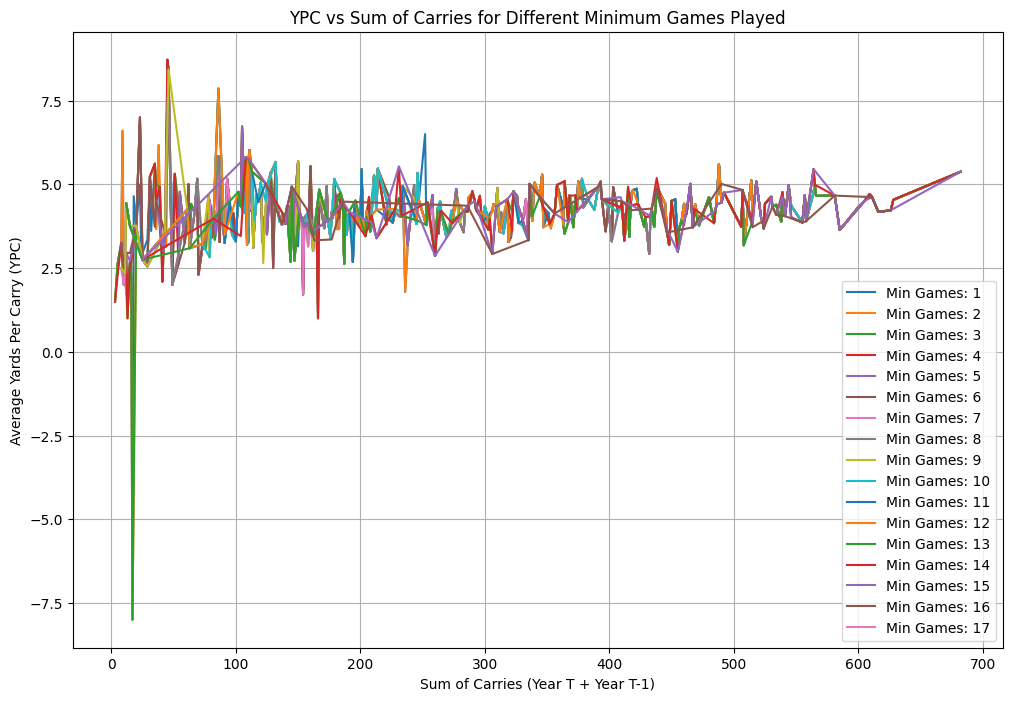

In [71]:
# Plotting
plt.figure(figsize=(12, 8))

for threshold, data in grouped_data.items():
    plt.plot(data['sum_carries'], data['yards_per_carry'], label=f'Min Games: {threshold}')

plt.xlabel('Sum of Carries (Year T + Year T-1)')
plt.ylabel('Average Yards Per Carry (YPC)')
plt.title('YPC vs Sum of Carries for Different Minimum Games Played')
plt.legend()
plt.grid(True)
plt.savefig("./YPC vs Sum of Carries for Different Minimum Games Played-all")
plt.show()

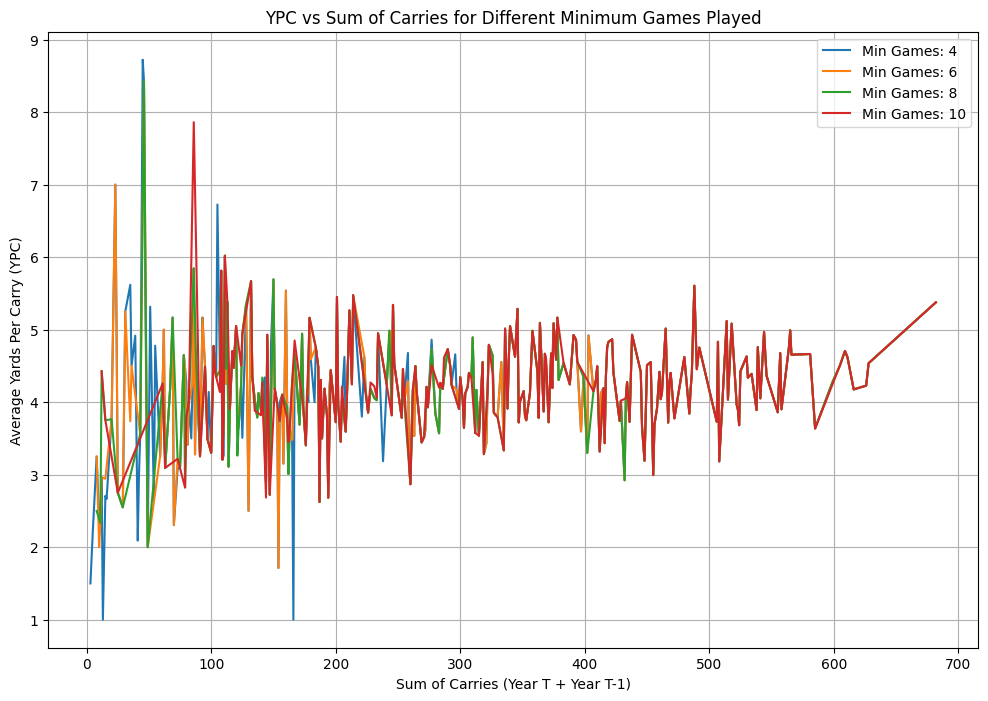

In [72]:
# Plotting
plt.figure(figsize=(12, 8))

for threshold, data in grouped_data.items():
    if threshold in [4, 6, 8, 10]:
        plt.plot(data['sum_carries'], data['yards_per_carry'], label=f'Min Games: {threshold}')

plt.xlabel('Sum of Carries (Year T + Year T-1)')
plt.ylabel('Average Yards Per Carry (YPC)')
plt.title('YPC vs Sum of Carries for Different Minimum Games Played')
plt.legend()
plt.grid(True)
plt.savefig("./YPC vs Sum of Carries for Different Minimum Games Played-4-6-8-10")
plt.show()

In [74]:
pwd

'/Users/alexbishka/Documents/Projects/Fantasy/Analysis/nfldataexploration/Rushing Stability'